# Classification Machine Learning Model

## Table of contents
1. [Introduction](#intro)
2. [Importing Libraries and Datasets](#Import)
3. [EDA and Preprocessing](#eda)<br>
   3.1. [Multicollienarity](#multi)
4. [Model Implementation with Pipeline](#model)<br>
   4.1. [Hyperparmater Tunning](#hyper)
5. [Saving Model for Production](#save)

## 1. Introduction <a class="anchor" id="intro"></a>

Goal: Apply different classification ML algorithms to predict whether a person is diabetic or not. 
    
The main purpose is to learn and understand each algorithm. 
At the end, the model with highest performance is used for deployment.  

## Importing Libraries and Dataset <a class="anchor" id="Import"></a>

In [1]:
#! pip install hyperopt

In [2]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scikitplot as skl
sns.set()

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, Binarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import  DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from genetic_selection import GeneticSelectionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neural_network import MLPClassifier

from skopt import BayesSearchCV

from catboost import CatBoostClassifier

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
import hyperopt as hp

from tqdm.notebook import tqdm

from time import time

import sys

import joblib

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

/home/xavier/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [3]:
# Dataset

data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA and Preprocessing <a class="anchor" id="eda"></a>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
# Exploring columns relationships

def explore_columns(data):
    plt.figure(figsize=(20,25), facecolor='white')
    plotnumber = 1

    for column in data:
        if plotnumber<=9 :     # as there are 9 columns in the data
            ax = plt.subplot(3,3,plotnumber)
            sns.distplot(data[column])
            plt.xlabel(column,fontsize=20)
            #plt.ylabel('Salary',fontsize=20)
        plotnumber+=1
    return plt.show()

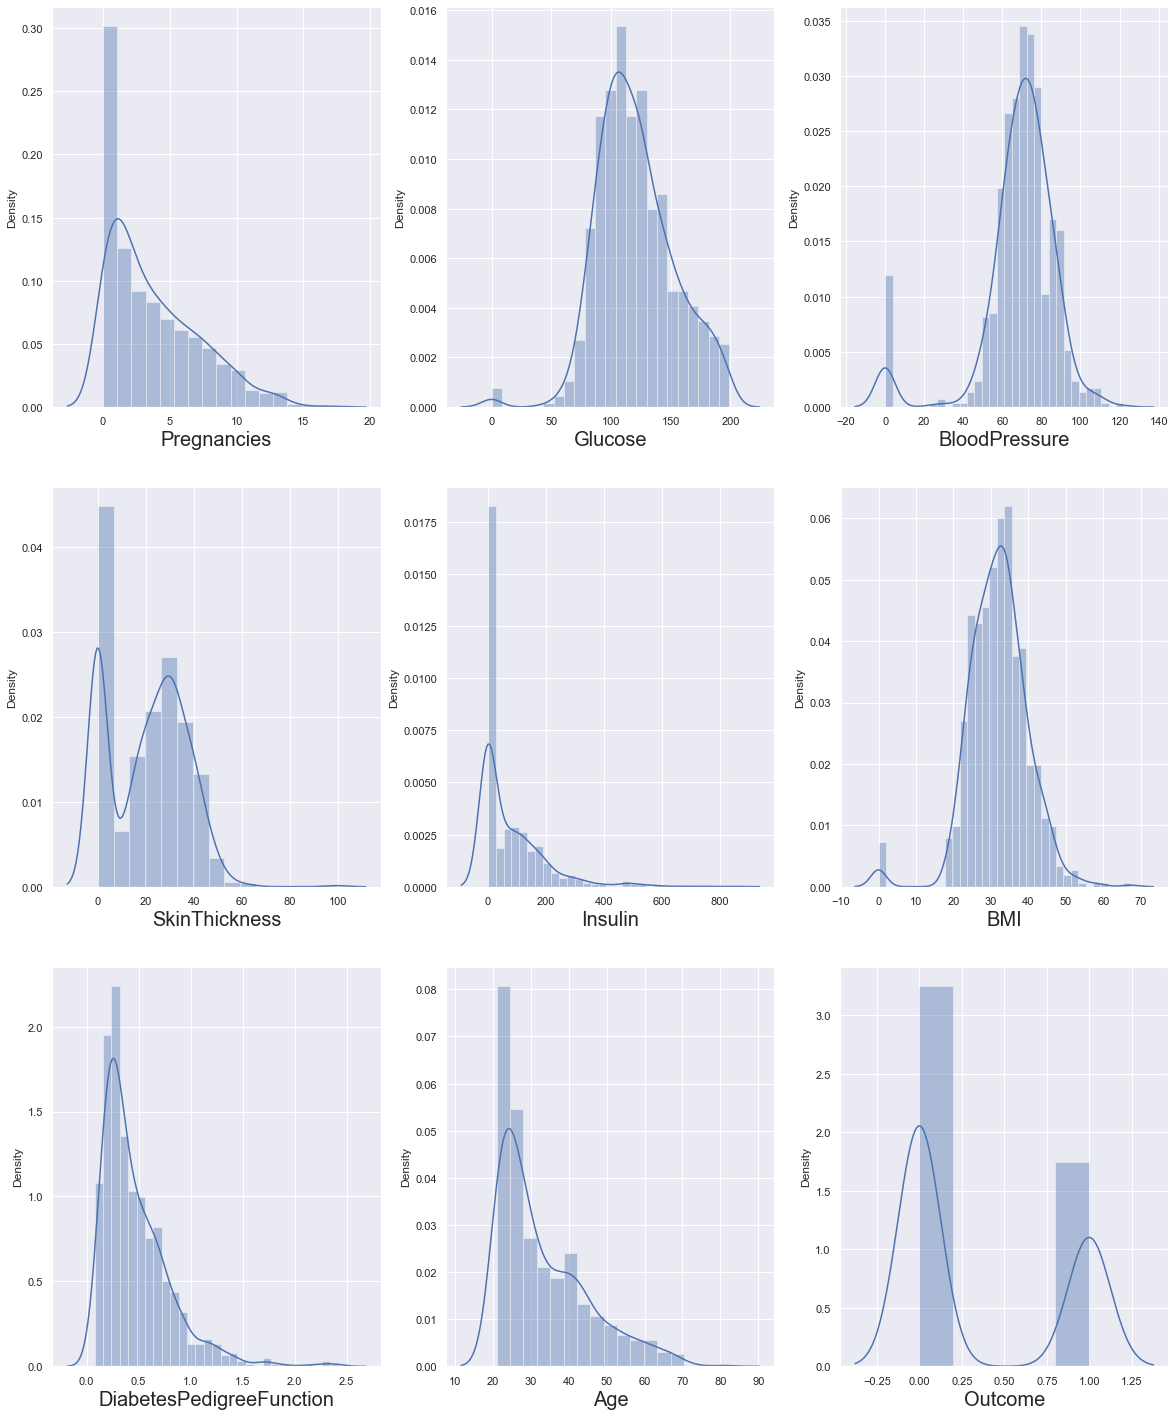

In [8]:
explore_columns(data)

There are data in columns Glucose, BloodPressure,SkinThickness, Insulin, BMI which have value as 0. That is not possible.
Let us replace those values with the mean.

In [9]:
data['Glucose'] = data['Glucose'].replace(0, data['Glucose'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0, data['SkinThickness'].mean())
data['Insulin'] = data['Insulin'].replace(0, data['Insulin'].mean())
data['BMI'] = data['BMI'].replace(0, data['BMI'].mean())

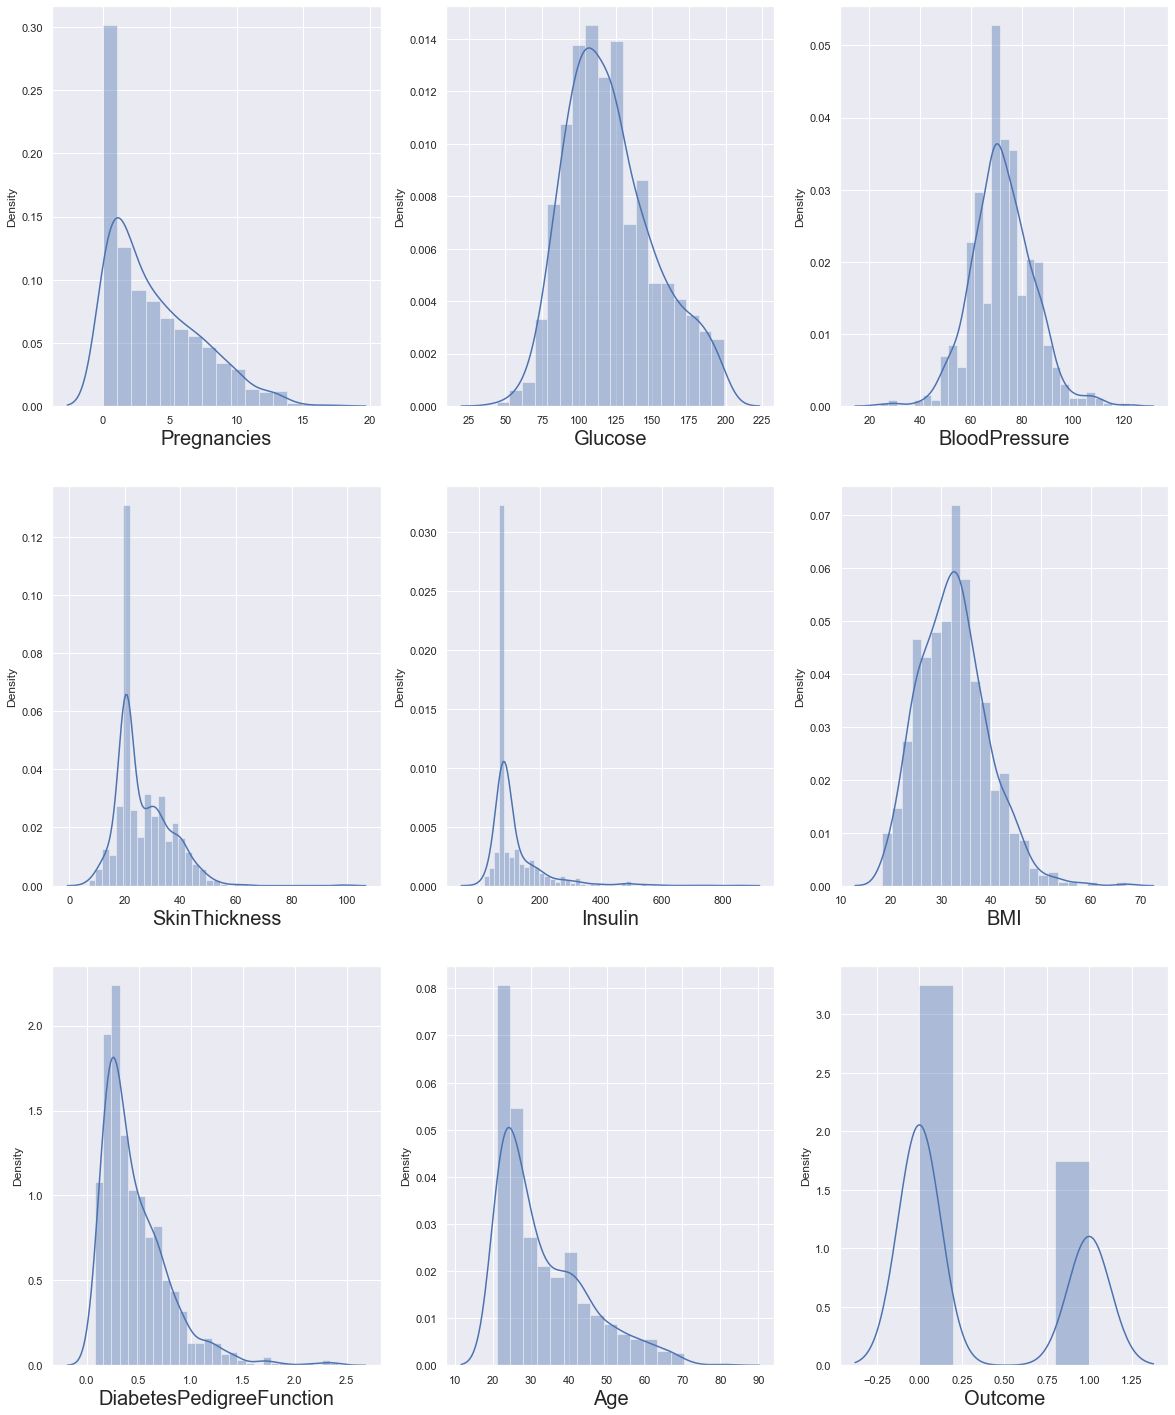

In [10]:
explore_columns(data)

<AxesSubplot:>

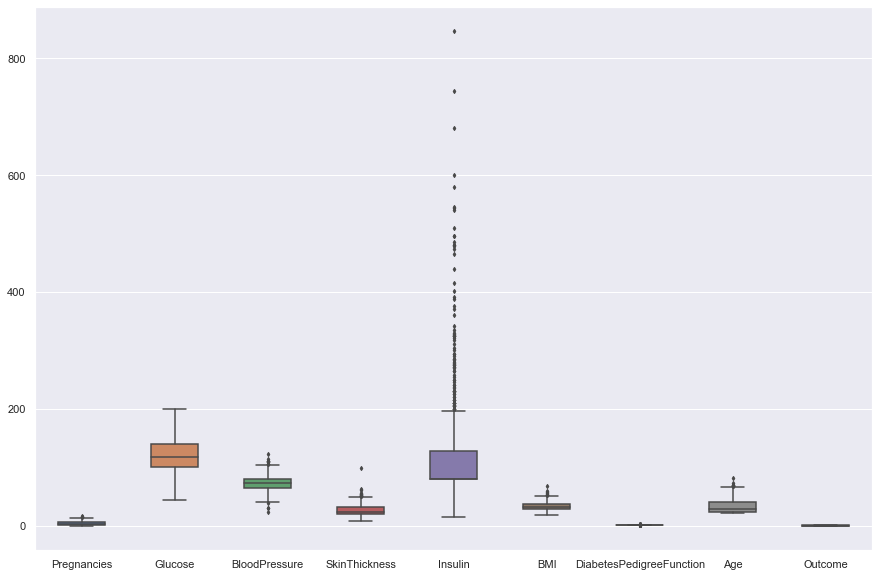

In [11]:
# Dealing with outliers

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data, width=0.5, ax=ax, fliersize=3)

Insuline column has many outliers

In [12]:
# Cleaning outliers using quantiles

q = data['Pregnancies'].quantile(0.98)
data_cleaned = data[data['Pregnancies']<q]  # removing the top 2% data from Pregnancies column

q = data_cleaned['BMI'].quantile(0.99)
data_cleaned = data_cleaned[data_cleaned['BMI']<q]

q = data_cleaned['SkinThickness'].quantile(0.99)
data_cleaned = data_cleaned[data_cleaned['SkinThickness']<q]

q =  data_cleaned['Insulin'].quantile(0.95)
data_cleaned = data_cleaned[data_cleaned['Insulin']<q]

q = data_cleaned['DiabetesPedigreeFunction'].quantile(0.99)
data_cleaned = data_cleaned[data_cleaned['DiabetesPedigreeFunction']<q]

q = data_cleaned['Age'].quantile(0.99)
data_cleaned = data_cleaned[data_cleaned['Age']<q]

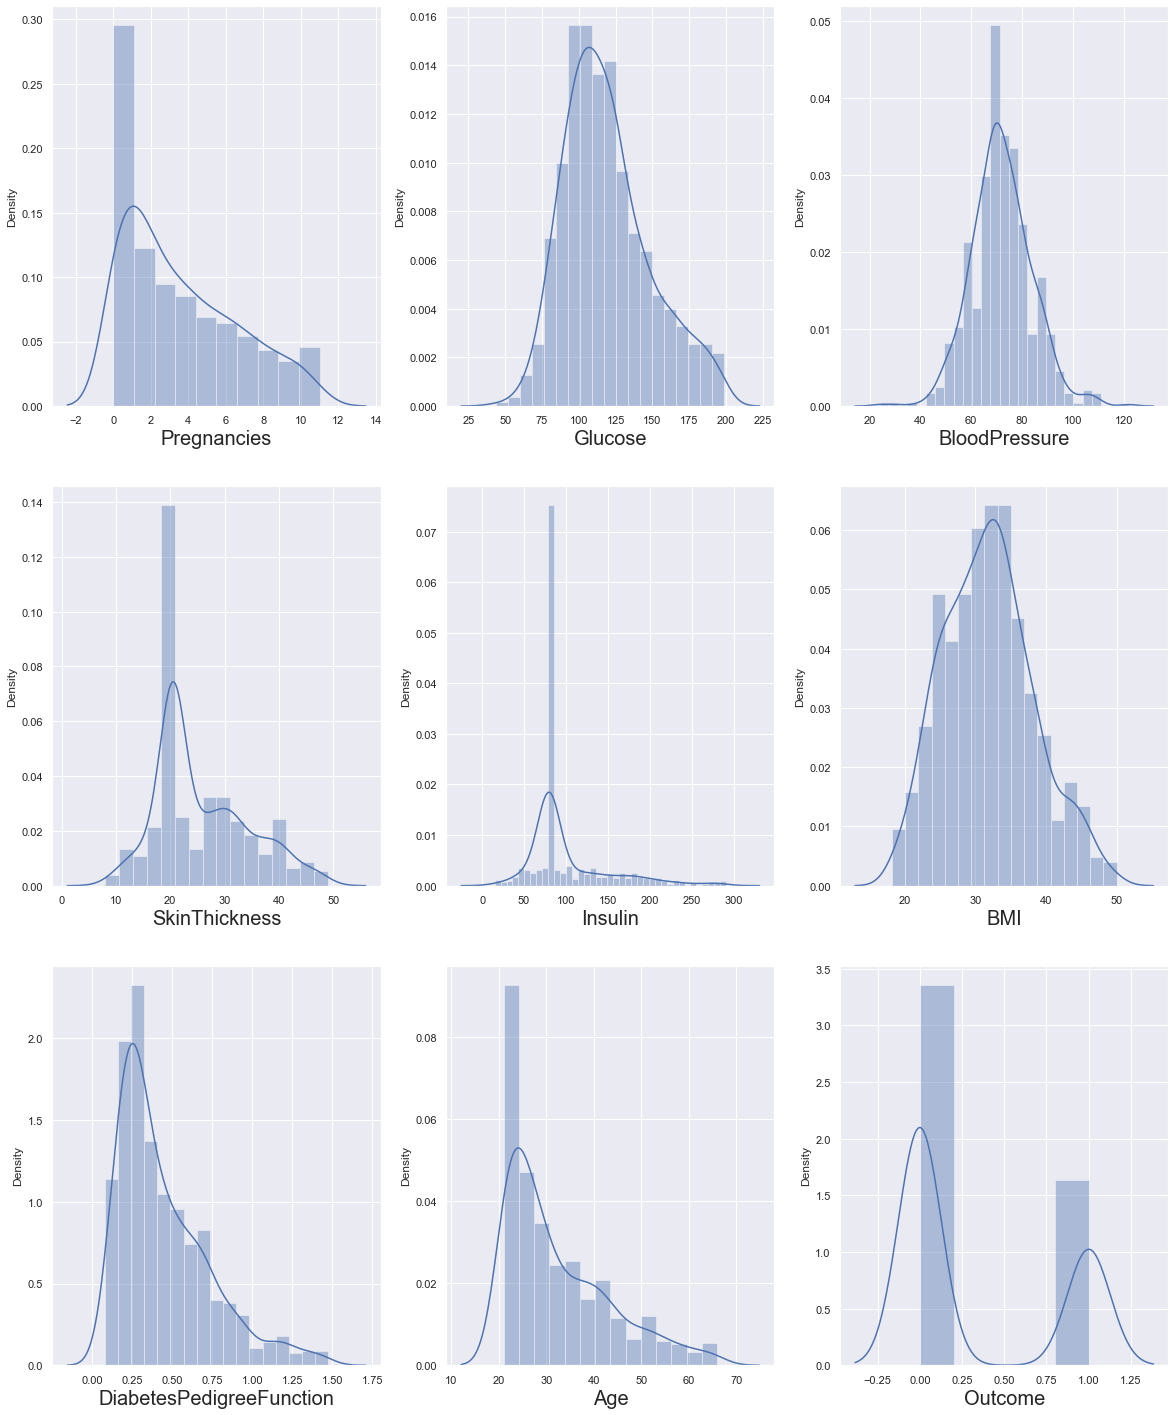

In [13]:
explore_columns(data_cleaned)

In [14]:
# Independent and dependent features

X = data.drop(columns=['Outcome'])
y = data['Outcome']

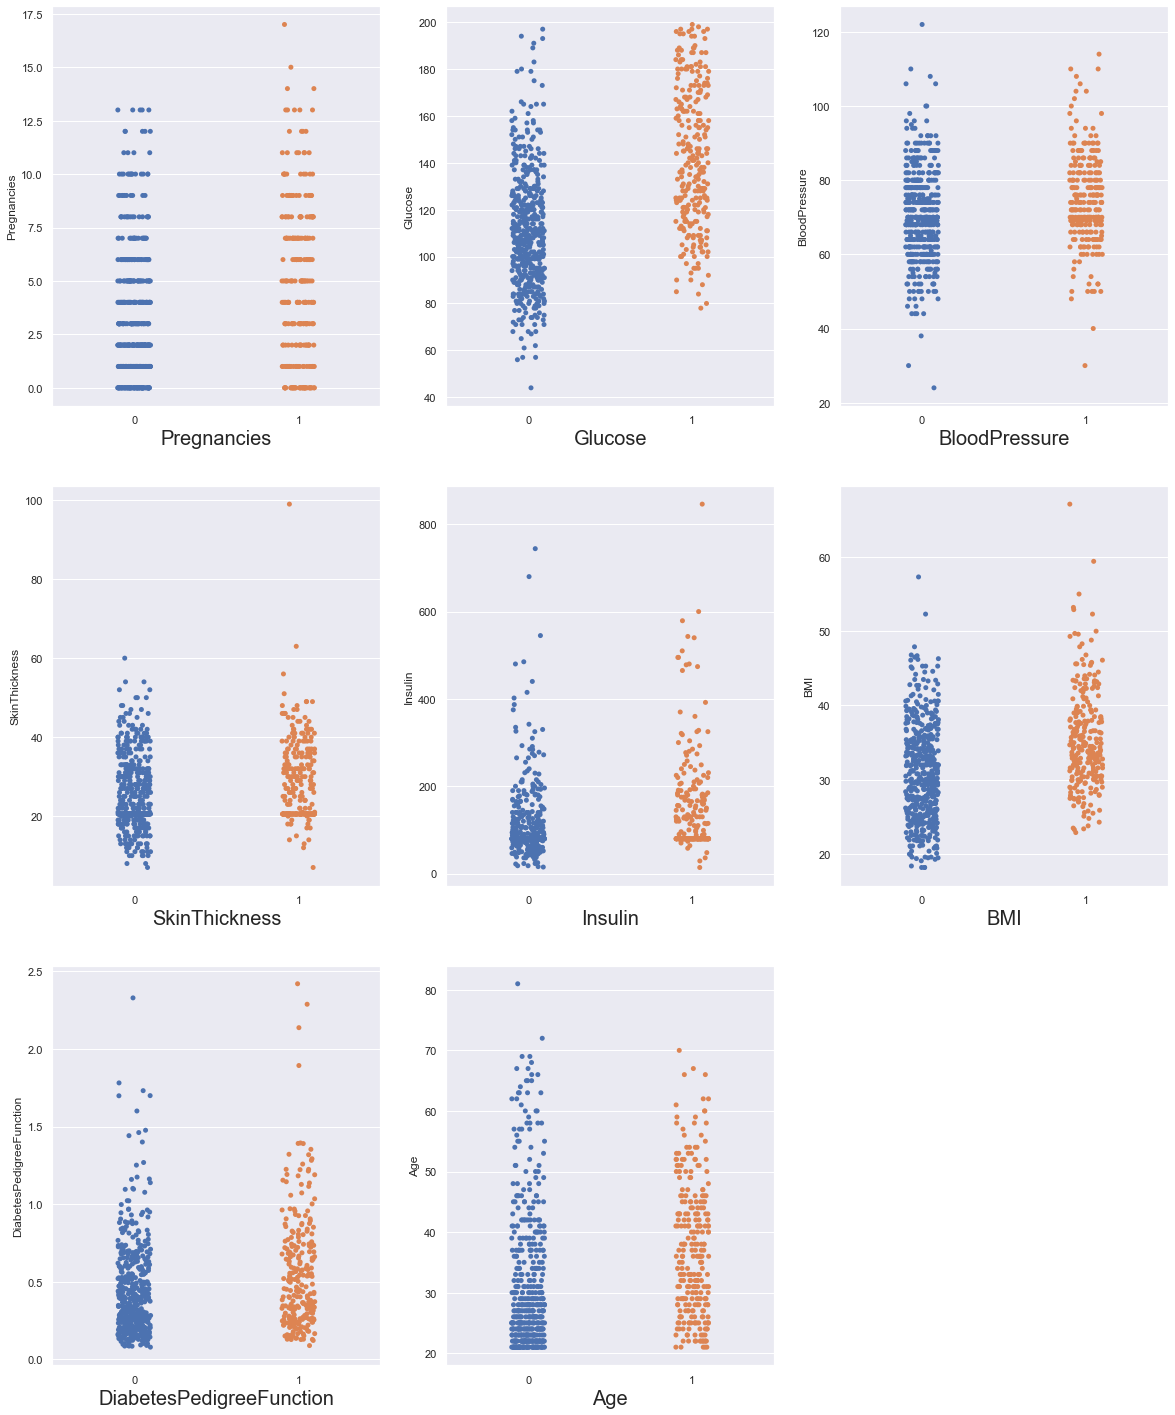

In [15]:
# Distribution of categories per colum

plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.stripplot(y, X[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

In [16]:
# Scaling data

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
X_scaled

array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.47378505, -0.87137393]])

In [17]:
X_scaled.shape

(768, 8)

In [18]:
type(X_scaled)

numpy.ndarray

### 3.1. Multicollienarity <a class="anchor" id="multi"></a>

[Multicollienarity](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/) it is a statistical phenomenon that occurs when two or more independent variables in a regression model are highly correlated with each other. In other words, this makes the effects of the predictors on the label very difficult to measure.

This can create challenges in the regression analysis because it becomes difficult to determine the individual effects of each independent variable on the dependent variable accurately.

VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.

In [19]:
# Check multicollienarity with VIF

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif['Features'] = X.columns
vif

,VIF,Features
0,1.431075,Pregnancies
1,1.347308,Glucose
2,1.247914,BloodPressure
3,1.450510,SkinThickness
4,1.262111,Insulin
5,1.550227,BMI
6,1.058104,DiabetesPedigreeFunction
7,1.605441,Age


VIF less than 5, there is no multicollienarity.

In [20]:
# Splitting train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=355)  #the same for all models

## 4. Model Implementation with pipeline <a class="anchor" id="model"></a>

We are going to use a sciki-learn Pipeline to design our model workflow.

In [48]:
# Define the models
models = [("logistic regression",LogisticRegression()),
          ("ridge classifier", RidgeClassifier()),
          ("bernoulli",BernoulliNB()),
          #('multinomial', MultinomialNB()),  # problems with negative values
          ("gaussian naive bayes", GaussianNB()),
          ("random forest",RandomForestClassifier()),
          ("SVM",SVC()),
          ("decision tree",DecisionTreeClassifier()),
          ("bagging", BaggingClassifier(DecisionTreeClassifier(),
                                    n_estimators=50,
                                    max_samples=0.5,
                                    bootstrap=True,
                                    random_state=355, oob_score=True)),
          ("pasting", BaggingClassifier(DecisionTreeClassifier(),
                                    n_estimators=50,
                                    max_samples=0.5,
                                    bootstrap=False,
                                    random_state=355)),
          ("XGBoost", XGBClassifier(objective='binary:logistic', random_state=355)),
          ("knn", KNeighborsClassifier()),
          ('SGD', SGDClassifier(loss='hinge', 
                                penalty='l2',
                                alpha=1e-3,
                                random_state=42,
                                max_iter=5,
                                tol=None)),
          ("adaboost", AdaBoostClassifier(n_estimators=50, random_state=355)),
          ("extra trees", ExtraTreesClassifier(n_estimators=50, random_state=355)),
          ("gradient boosting", GradientBoostingClassifier(n_estimators=50, random_state=355)),
          ("voting", VotingClassifier(estimators=[('lr', LogisticRegression()),
                                            ('rf', RandomForestClassifier()),
                                            ('svm', SVC())], voting='hard')),
          ("mlp", MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=355)),
          ('Perceptron', Perceptron(class_weight='balanced')),
          ('catboost', CatBoostClassifier(verbose=0)),
          ('LDA', LinearDiscriminantAnalysis())
]

scores_combined = []
times = []
confusion_mat_combined = []

# Loop of models
for (name,model) in tqdm(models):
    t1 = time()
    print(f"processing model {name} ")
    pipeline = Pipeline([
        ('normalization', StandardScaler()),
        ("classifier", model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Fit and predict
    y_pred = pipeline.predict(X_test)
    
    # Metrics 
    score = accuracy_score(y_pred=y_pred,y_true=y_test)
    f1_score_result = f1_score(y_pred=y_pred,y_true=y_test) 
    precision_score_result = precision_score(y_pred=y_pred,y_true=y_test)
    recall_score_result = recall_score(y_pred=y_pred,y_true=y_test)
    roc_auc_score_result = roc_auc_score(y_pred, y_test)
    
    print("Score = {:.2f}%".format(score*100))
    print('F1 score = {:.2f}%'.format(f1_score_result * 100))
    print("Recall score = {:.2f}%".format(recall_score_result * 100))
    print("Precison score = {:.2f}%".format(precision_score_result * 100))
    print("ROC AUC score = {:.2f}%".format(roc_auc_score_result))
    print(classification_report(y_test, y_pred))
    print('----------------------------------------')
    
    # Confusion matrix
    conf_mat = confusion_matrix(y_pred=y_pred,y_true=y_test)
    
    # Append results
    scores_combined.append((name,
                            score,
                            f1_score_result,
                            precision_score_result,
                            recall_score_result,
                            roc_auc_score_result))
    
    confusion_mat_combined.append((name,
                                  conf_mat))
    
    t2 = time()
    times.append((name,t2-t1))

  0%|          | 0/20 [00:00<?, ?it/s]

processing model logistic regression 
Score = 75.52%
F1 score = 59.83%
Recall score = 52.24%
Precison score = 70.00%
ROC AUC score = 0.74%
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       125
           1       0.70      0.52      0.60        67

    accuracy                           0.76       192
   macro avg       0.74      0.70      0.71       192
weighted avg       0.75      0.76      0.75       192

----------------------------------------
processing model ridge classifier 
Score = 74.48%
F1 score = 57.39%
Recall score = 49.25%
Precison score = 68.75%
ROC AUC score = 0.73%
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       125
           1       0.69      0.49      0.57        67

    accuracy                           0.74       192
   macro avg       0.73      0.69      0.70       192
weighted avg       0.74      0.74      0.73       192

------------------------------

Score = 72.92%
F1 score = 58.06%
Recall score = 53.73%
Precison score = 63.16%
ROC AUC score = 0.70%
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       125
           1       0.63      0.54      0.58        67

    accuracy                           0.73       192
   macro avg       0.70      0.68      0.69       192
weighted avg       0.72      0.73      0.72       192

----------------------------------------
processing model LDA 
Score = 73.96%
F1 score = 56.90%
Recall score = 49.25%
Precison score = 67.35%
ROC AUC score = 0.72%
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       125
           1       0.67      0.49      0.57        67

    accuracy                           0.74       192
   macro avg       0.72      0.68      0.69       192
weighted avg       0.73      0.74      0.73       192

----------------------------------------


In [49]:
# Show results in a table

scores_combined_df = pd.DataFrame(scores_combined, columns=['Model',
                                                            'Accuracy',
                                                            'F1 Accuracy',
                                                            'Recall',
                                                            'Precision',
                                                            'ROC AUC'])
print("Sorting by Accuracy")
scores_sorted = scores_combined_df.sort_values('Accuracy', ascending=False)
scores_sorted = scores_sorted.reset_index(drop=True)
scores_sorted

Sorting by Accuracy


,Model,Accuracy,F1 Accuracy,Recall,Precision,ROC AUC
0,adaboost,0.791667,0.672131,0.745455,0.611940,0.777837
1,gaussian naive bayes,0.786458,0.672000,0.724138,0.626866,0.768785
2,voting,0.760417,0.596491,0.723404,0.507463,0.747909
3,pasting,0.760417,0.622951,0.690909,0.567164,0.739615
4,logistic regression,0.755208,0.598291,0.700000,0.522388,0.737324
5,random forest,0.755208,0.605042,0.692308,0.537313,0.735440
6,gradient boosting,0.755208,0.617886,0.678571,0.567164,0.732668
7,bagging,0.750000,0.593220,0.686275,0.522388,0.729662
8,extra trees,0.750000,0.593220,0.686275,0.522388,0.729662
9,SVM,0.744792,0.558559,0.704545,0.462687,0.730651


Adaboost and Gaussian Naive Bayes are the best models. Let us optimize those models with hyperparameter tunning.

In [50]:
# Plots

# Number of rows and columns for subplots
num_rows = 7
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12), dpi=700)
fig.subplots_adjust(hspace=0.5)

# Loop through the models and plot confusion matrices
for index, row in scores_sorted.iterrows():
    model_name = row['Model']
    i = index // num_cols
    j = index % num_cols
   
    cm = confusion_mat_combined[j][1]
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=.5, annot_kws={"size": 10}, ax=axes[i, j])
    axes[i, j].set_title(f"{model_name}\nAcc: {row['Accuracy']:.2f}, F1 Acc: {row['F1 Accuracy']:.2f}")
    #axes[i, j].set_xlabel("Predicted")
    #axes[i, j].set_ylabel("True")

plt.show()

### 4.1. Hyperparameter Tunning <a class="anchor" id="hyper"></a>

In [139]:
# HT function

scores_hyp_tunning = []

def hyper_tunning(X_train, y_train, param_grid, model, h_t_method, save_model):
    '''
    Computing hyperparameter tunning and cross validation based on tree different methods:
    1. Exhaustive GridSearchCV: 
    2. Randomized RandomizedSearchCV
    3. Bayesian Optimization
    
    parameters:
    - X_train: Trained dataset
    - y_train: Trained labels
    - param_grid: Hyperparameters grid
    - model: Machine Learning algorithm
    - h_t_method:
                 - 'grid' -> GridSearchCV
                 - 'random' -> RandomizedSearchCV
                 - 'bayesian' -> Bayesian Optimization
    - save model: Yes                 
    '''
    
    t1 = time()
    
    # Create the pipeline
    pipe = Pipeline([
        ('normalization', StandardScaler()),
        ("classifier", model)
    ])

    # Create StratifiedKFold instance
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Select method
    if h_t_method == 'grid':
        # Create GridSearchCV instance with StratifiedKFold
        grid_search = GridSearchCV(pipe,
                                   param_grid,
                                   cv=stratified_kfold,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   verbose=1
                                  )
    elif h_t_method == 'random':
        # Random method
        grid_search = RandomizedSearchCV(pipe,
                                         param_grid,
                                         cv=stratified_kfold,
                                          scoring="roc_auc",
                                          n_jobs=-1,
                                          n_iter=5,
                                          verbose=1
                                         )

    elif h_t_method == 'bayesian':
        # Bayesian Optimization
        grid_search = BayesSearchCV(pipe,
                                    param_grid,
                                    n_iter=20,  # Number of optimization steps
                                    cv=stratified_kfold,  # Number of cross-validation folds
                                    n_jobs=-1,  # Use all available CPUs
                                    n_points=1,  # Number of parameter settings proposed in each iteration
                                    scoring='roc_auc',
                                    verbose=1
                                   )
        
    else:
        # Default
        grid_search = GridSearchCV(pipe,
                                   param_grid,
                                   cv=stratified_kfold,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   verbose=1
                                  )

    # Fit the pipeline with hyperparameter tuning and cross-validation
    grid_search.fit(X_train, y_train)

    # Print the best parameters and the corresponding accuracy score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    roc_auc_result = roc_auc_score(y_pred, y_test)
    print("Best ROC AUC: {:.2f}%".format(roc_auc_result * 100))
    
    # Append results
    scores_hyp_tunning.append((h_t_method,
                               grid_search.best_score_ * 100,
                               roc_auc_result * 100))
    
    # Save the model
    if save_model == 'save model':
        best_model = grid_search.best_estimator_
        joblib.dump(best_model, 'classificationModel.sav')
    else:
        return None

    return 'classificationModel.sav'

In [116]:
# Adaboost

param_grid_adaboost = {#'classifier__base_estimator__max_depth':[i for i in range(2,11,2)],
              #'classifier__base_estimator__min_samples_leaf':[5,10],
              'classifier__n_estimators':[10,50,250,1000],
              'classifier__learning_rate':[0.01,0.1]}

hyper_tunning(X_train,
              y_train,
              param_grid_adaboost,
              AdaBoostClassifier(),
              'grid',
              '')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.9s finished


Best Parameters:  {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 250}
Best Accuracy: 83.69%
Best ROC AUC: 71.23%


In [117]:
hyper_tunning(X_train,
              y_train,
              param_grid_adaboost,
              AdaBoostClassifier(),
              'random',
              '')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.4s finished


Best Parameters:  {'classifier__n_estimators': 250, 'classifier__learning_rate': 0.01}
Best Accuracy: 83.69%
Best ROC AUC: 71.23%


In [118]:
hyper_tunning(X_train,
              y_train,
              param_grid_adaboost,
              AdaBoostClassifier(),
              'bayesian',
              '')

Best Parameters:  OrderedDict([('classifier__learning_rate', 0.07223549181431123), ('classifier__n_estimators', 50)])
Best Accuracy: 83.96%
Best ROC AUC: 72.47%


In [119]:
# Show results in a table
scores_hyp_tunning_df = pd.DataFrame(scores_hyp_tunning, columns=['Model',
                                                                  'Accuracy',
                                                                  'ROC AUC'])
print("Sorting by Accuracy")
scores_hyp_tunning_sorted = scores_hyp_tunning_df.sort_values('Accuracy', ascending=False)
scores_hyp_tunning_sorted = scores_hyp_tunning_sorted.reset_index(drop=True)
scores_hyp_tunning_sorted

Sorting by Accuracy


,Model,Accuracy,ROC AUC
0,bayesian,83.959371,72.467614
1,grid,83.692439,71.232434
2,random,83.692439,71.232434


In [120]:
scores_hyp_tunning = []

In [121]:
# Gaussian Bayesian

param_grid_bn = {'classifier__priors': [None],
                 'classifier__var_smoothing': [0.00000001, 0.000000001, 0.00000001]
                }

hyper_tunning(X_train,
              y_train,
              param_grid_bn,
              GaussianNB(),
              'grid',
              '')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters:  {'classifier__priors': None, 'classifier__var_smoothing': 1e-08}
Best Accuracy: 81.27%
Best ROC AUC: 76.88%


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


In [122]:
hyper_tunning(X_train,
              y_train,
              param_grid_bn,
              GaussianNB(),
              'random',
              '')              

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters:  {'classifier__var_smoothing': 1e-08, 'classifier__priors': None}
Best Accuracy: 81.27%
Best ROC AUC: 76.88%


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


In [126]:
#hyper_tunning(X_train,
#              y_train,
#              param_grid_bn,
#              GaussianNB(),
#              'bayesian',
#              '')

In [124]:
# Show results in a table
scores_hyp_tunning_df = pd.DataFrame(scores_hyp_tunning, columns=['Model',
                                                                  'Accuracy',
                                                                  'ROC AUC'])
print("Sorting by Accuracy")
scores_hyp_tunning_sorted = scores_hyp_tunning_df.sort_values('Accuracy', ascending=False)
scores_hyp_tunning_sorted = scores_hyp_tunning_sorted.reset_index(drop=True)
scores_hyp_tunning_sorted

Sorting by Accuracy


,Model,Accuracy,ROC AUC
0,grid,81.270407,76.878538
1,random,81.270407,76.878538


In [140]:
# Random Forest

param_grid_random = {
    "classifier__n_estimators" : [90,100],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth' : range(2,20,1),
    'classifier__min_samples_leaf' : range(1,10,1),
    'classifier__min_samples_split': range(2,10,1),
    'classifier__max_features' : ['auto','log2']
}

hyper_tunning(X_train,
              y_train,
              param_grid_random,
              RandomForestClassifier(),
              'grid',
              '')

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 51840 out of 51840 | elapsed: 298.5min finished


Best Parameters:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 90}
Best Accuracy: 85.24%
Best ROC AUC: 73.73%


In [141]:
hyper_tunning(X_train,
              y_train,
              param_grid_random,
              RandomForestClassifier(),
              'random',
              '')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.0s finished


Best Parameters:  {'classifier__n_estimators': 90, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 'log2', 'classifier__max_depth': 16, 'classifier__criterion': 'entropy'}
Best Accuracy: 84.28%
Best ROC AUC: 72.38%


## Saving Model for Production <a class="anchor" id="save"></a>

The best model has been found by the Bayesian hyperparamter optimization process using the AdaBoostClassifier() model. Let us save it.

In [143]:
hyper_tunning(X_train,
              y_train,
              param_grid_adaboost,
              AdaBoostClassifier(),
              'grid',
              'save model')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   45.7s finished


Best Parameters:  {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 250}
Best Accuracy: 83.69%
Best ROC AUC: 71.23%


'classificationModel.sav'